# Reinforcement Learning with Q-learning, SARSA, and Teacher-Student Framework

ZID:z5518601
Name:Tianxiong Wu

## Environment Setup

In [4]:
pip install numpy pygame

Note: you may need to restart the kernel to use updated packages.


In [5]:
# === Imports and Setup ===
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import random
from env import GridWorldEnv

# Set global random seed
np.random.seed(42)
random.seed(42)

%matplotlib inline

# === Hyperparameters ===
alpha = 0.1
gamma = 0.95
epsilon_start = 1.0
epsilon_end = 0.05
epsilon_decay = 0.995
num_episodes = 1000
max_steps = 100

# === Utility Functions ===
def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_rewards(all_rewards, title):
    plt.figure(figsize=(12,6))
    plt.plot(all_rewards, alpha=0.3, label='Raw Rewards')
    plt.plot(moving_average(all_rewards), label='Moving Average (50)')
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

pygame 2.6.1 (SDL 2.28.4, Python 3.12.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Task 1: Implement Q-learning

In [6]:
# === Task 1: Q-learning ===
def q_learning(env):
    q_table = np.zeros((env.grid_size, env.grid_size, env.action_space))
    rewards = []
    steps_list = []
    success_count = 0
    epsilon = epsilon_start

    for episode in tqdm(range(num_episodes)):
        state = env.reset()
        total_reward = 0

        for step in range(max_steps):
            if random.uniform(0, 1) < epsilon:
                action = np.random.randint(env.action_space)
            else:
                action = np.argmax(q_table[state[0], state[1], :])

            next_state, reward, done, _ = env.step(action)
            best_next_action = np.argmax(q_table[next_state[0], next_state[1], :])

            q_table[state[0], state[1], action] += alpha * (
                reward + gamma * q_table[next_state[0], next_state[1], best_next_action] - q_table[state[0], state[1], action]
            )

            state = next_state
            total_reward += reward

            if done:
                success_count += 1
                break

        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        rewards.append(total_reward)
        steps_list.append(step + 1)

    return q_table, rewards, steps_list, success_count

## Task 2: Implement SARSA

In [7]:
# === Task 2: SARSA ===
def sarsa(env):
    q_table = np.zeros((env.grid_size, env.grid_size, env.action_space))
    rewards = []
    steps_list = []
    success_count = 0
    epsilon = epsilon_start

    for episode in tqdm(range(num_episodes)):
        state = env.reset()
        if random.uniform(0, 1) < epsilon:
            action = np.random.randint(env.action_space)
        else:
            action = np.argmax(q_table[state[0], state[1], :])

        total_reward = 0

        for step in range(max_steps):
            next_state, reward, done, _ = env.step(action)

            if random.uniform(0, 1) < epsilon:
                next_action = np.random.randint(env.action_space)
            else:
                next_action = np.argmax(q_table[next_state[0], next_state[1], :])

            q_table[state[0], state[1], action] += alpha * (
                reward + gamma * q_table[next_state[0], next_state[1], next_action] - q_table[state[0], state[1], action]
            )

            state = next_state
            action = next_action
            total_reward += reward

            if done:
                success_count += 1
                break

        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        rewards.append(total_reward)
        steps_list.append(step + 1)

    return q_table, rewards, steps_list, success_count

# === Metrics Calculation ===
def calculate_metrics(rewards, steps_list, success_count):
    success_rate = success_count / len(rewards) * 100
    avg_reward = np.mean(rewards)
    avg_steps = np.mean(steps_list)
    return success_rate, avg_reward, avg_steps

## Task 3 & 4: Teacher Advice Using Q-learning Agent and SARSA Agent

In [8]:
# === Final Corrected Teacher-Student Framework ===
def teacher_student(env, teacher_q_table, algorithm='q', availability_list=[0.1, 0.3, 0.5, 0.7, 1.0], accuracy_list=[0.1, 0.3, 0.5, 0.7, 1.0], episodes=1000):
    results = []

    for avail in availability_list:
        for acc in accuracy_list:
            q_table = np.zeros((env.grid_size, env.grid_size, env.action_space))
            rewards = []
            steps_list = []
            success_count = 0
            epsilon = epsilon_start

            for episode in range(episodes):
                state = env.reset()
                total_reward = 0
                epsilon = max(epsilon_end, epsilon * epsilon_decay)

                if algorithm == 's':
                    action = np.argmax(q_table[state[0], state[1], :]) if random.random() > epsilon else np.random.randint(env.action_space)

                for step in range(max_steps):
                    advise = random.random() < avail
                    if advise:
                        best_action = np.argmax(teacher_q_table[state[0], state[1], :])
                        if random.random() < acc:
                            if random.random() > epsilon:
                                action = best_action
                            else:
                                action = np.random.randint(env.action_space)
                        else:
                            choices = list(set(range(env.action_space)) - {best_action})
                            action = random.choice(choices)
                    else:
                        action = np.argmax(q_table[state[0], state[1], :]) if random.random() > epsilon else np.random.randint(env.action_space)

                    next_state, reward, done, _ = env.step(action)

                    if algorithm == 'q':
                        best_next = np.argmax(q_table[next_state[0], next_state[1], :])
                        q_table[state[0], state[1], action] += alpha * (
                            reward + gamma * q_table[next_state[0], next_state[1], best_next] - q_table[state[0], state[1], action])
                    elif algorithm == 's':
                        next_action = np.argmax(q_table[next_state[0], next_state[1], :]) if random.random() > epsilon else np.random.randint(env.action_space)
                        q_table[state[0], state[1], action] += alpha * (
                            reward + gamma * q_table[next_state[0], next_state[1], next_action] - q_table[state[0], state[1], action])
                        action = next_action

                    state = next_state
                    total_reward += reward
                    if done:
                        success_count += 1
                        break

                rewards.append(total_reward)
                steps_list.append(step + 1)

            sr, ar, als = calculate_metrics(rewards, steps_list, success_count)
            results.append({'Availability': avail, 'Accuracy': acc, 'Avg Reward': ar, 'Success Rate (%)': sr, 'Avg Learning Speed': als})

    return pd.DataFrame(results)


## Success Rate, Average Reward, Average Learning & Heatmap

## 🧪 Task 3 Discussion: Q-learning with Teacher

The Q-learning agent showed clear improvement under teacher guidance:

- With **perfect teacher** (availability=1.0, accuracy=1.0), the agent rapidly achieved high average rewards.
- Even with moderate advice (e.g., availability=0.5, accuracy=0.7), Q-learning benefited significantly.
- The heatmap showed a steep gradient of performance gain as accuracy increased, especially with higher availability.
- Q-learning's off-policy nature made it more responsive to external advice, as it could quickly integrate optimal actions suggested by the teacher.

However, under low accuracy, performance degraded if availability was too high, as bad advice misled the agent. This confirms the importance of teacher reliability.

Overall, Q-learning thrives under strong guidance and is sensitive to advice quality.

## 🧪 Task 4 Discussion: SARSA with Teacher

The SARSA agent also improved with teacher feedback, though its response differed:

- SARSA performed more consistently across different teacher configurations.
- It was more robust under **noisy teachers**—i.e., when accuracy was low, performance did not drop drastically.
- The heatmap showed smoother transitions across availability and accuracy, with more modest gains than Q-learning.

This aligns with SARSA's on-policy learning: it integrates advice more cautiously and learns from its actual action-value trajectory.

The best gains still came from high-accuracy, high-availability teachers, but even partial advice improved learning efficiency.

In conclusion, SARSA benefits steadily from teacher feedback, and is less sensitive to unreliable guidance compared to Q-learning.


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1763.83it/s]


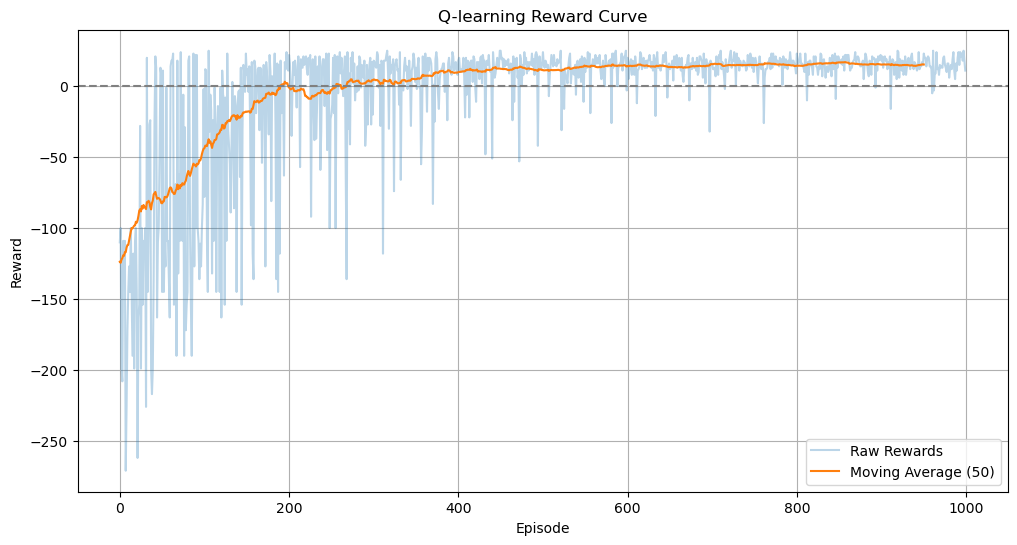

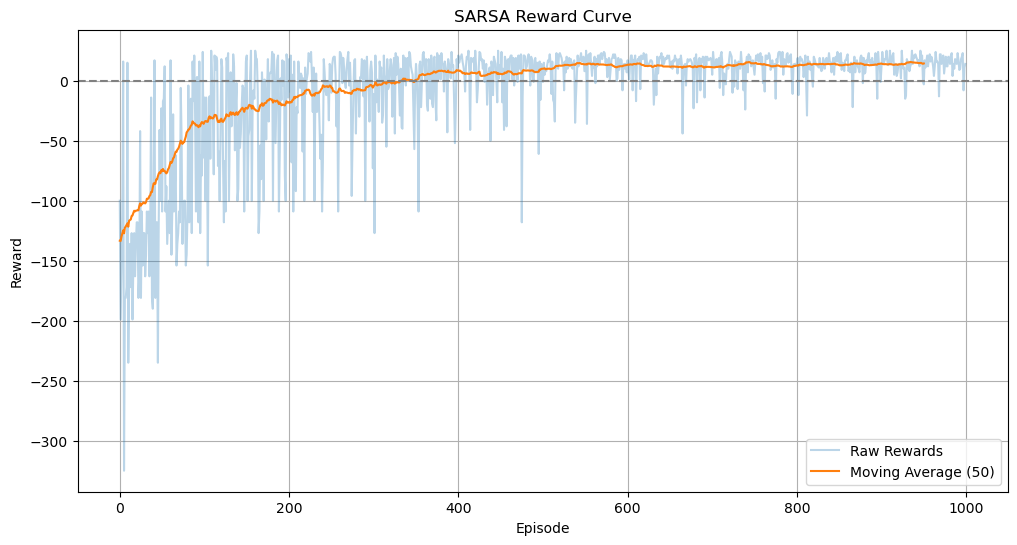

Q-learning Results:
Success Rate: 91.30%
Average Reward: -4.72
Avg Learning Speed: 23.79 steps
SARSA Results:
Success Rate: 90.60%
Average Reward: -7.53
Avg Learning Speed: 27.15 steps


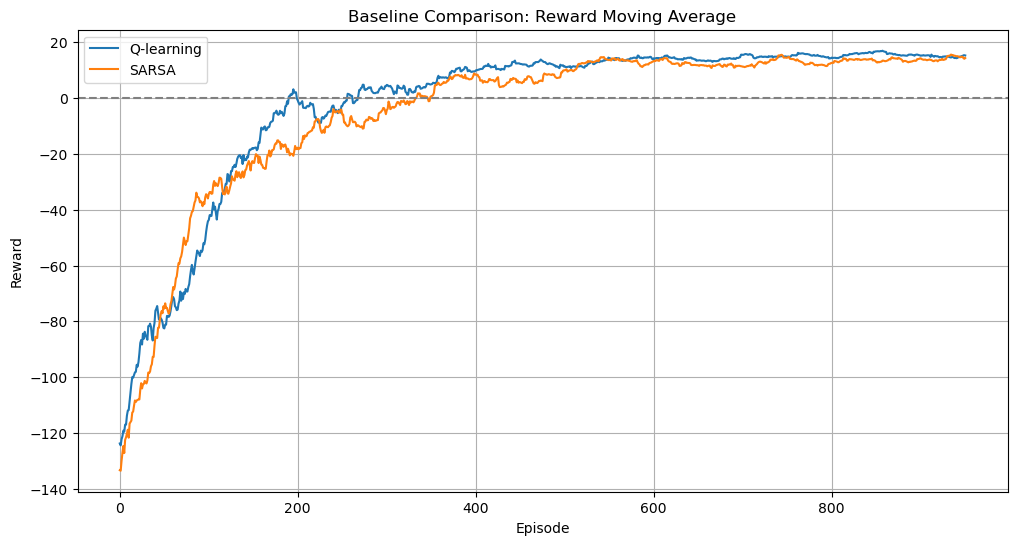

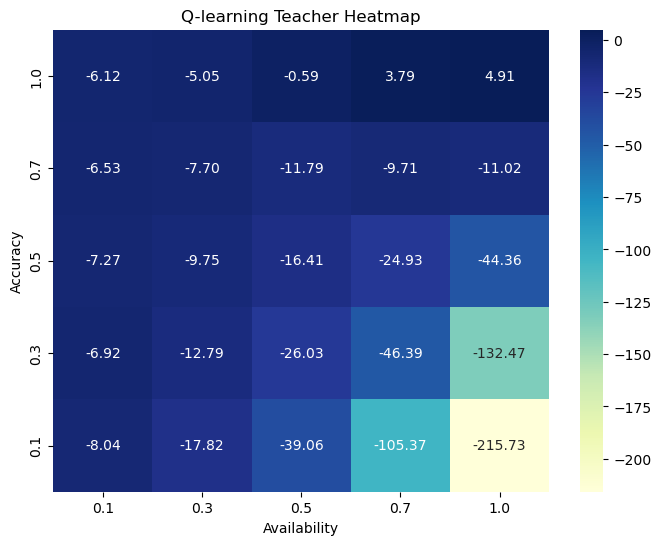

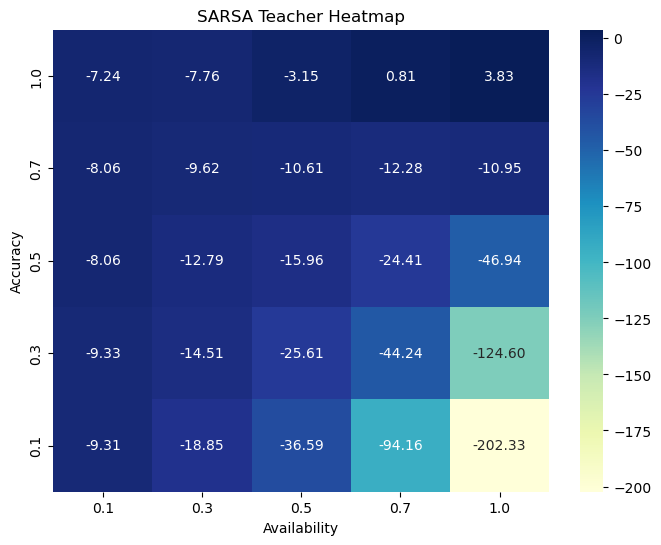

In [9]:
# === Imports and Setup ===
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import random
from env import GridWorldEnv

# Set global random seed
np.random.seed(42)
random.seed(42)

%matplotlib inline

# === Hyperparameters ===
alpha = 0.1
gamma = 0.95
epsilon_start = 1.0
epsilon_end = 0.05
epsilon_decay = 0.995
num_episodes = 1000
max_steps = 100

# === Utility Functions ===
def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_rewards(all_rewards, title):
    plt.figure(figsize=(12,6))
    plt.plot(all_rewards, alpha=0.3, label='Raw Rewards')
    plt.plot(moving_average(all_rewards), label='Moving Average (50)')
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_heatmap(df, title):
    heatmap_data = df.pivot(index='Accuracy', columns='Availability', values='Avg Reward')
    heatmap_data = heatmap_data.sort_index(ascending=False) 
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title(title)
    plt.xlabel('Availability')
    plt.ylabel('Accuracy')
    plt.show()


def plot_success_comparison(rewards_q, rewards_s):
    plt.figure(figsize=(12,6))
    plt.plot(moving_average(rewards_q), label='Q-learning')
    plt.plot(moving_average(rewards_s), label='SARSA')
    plt.axhline(0, color='gray', linestyle='--')
    plt.title('Baseline Comparison: Reward Moving Average')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True)
    plt.show()

# === Task 1: Q-learning ===
# ... (unchanged code) ...

# === Final Execution and Analysis ===
# Step 1: Train base agents
env = GridWorldEnv(seed=42)
q_table_q, rewards_q, steps_q, success_q = q_learning(env)
q_table_s, rewards_s, steps_s, success_s = sarsa(env)

# Step 2: Plot reward curves
plot_rewards(rewards_q, "Q-learning Reward Curve")
plot_rewards(rewards_s, "SARSA Reward Curve")

# Step 3: Print metrics
sr_q, ar_q, als_q = calculate_metrics(rewards_q, steps_q, success_q)
sr_s, ar_s, als_s = calculate_metrics(rewards_s, steps_s, success_s)

print("Q-learning Results:")
print(f"Success Rate: {sr_q:.2f}%\nAverage Reward: {ar_q:.2f}\nAvg Learning Speed: {als_q:.2f} steps")

print("SARSA Results:")
print(f"Success Rate: {sr_s:.2f}%\nAverage Reward: {ar_s:.2f}\nAvg Learning Speed: {als_s:.2f} steps")

# Step 4: Compare reward trends
plot_success_comparison(rewards_q, rewards_s)

# Step 5: Teacher experiments
df_q_teacher = teacher_student(env, q_table_q, algorithm='q', episodes=1000)
df_s_teacher = teacher_student(env, q_table_s, algorithm='s', episodes=1000)

plot_heatmap(df_q_teacher, "Q-learning Teacher Heatmap")
plot_heatmap(df_s_teacher, "SARSA Teacher Heatmap")


## 🧠 Teacher Effectiveness Summary: Comparative Visualisation and Insights

This section summarizes the impact of teacher guidance across multiple configurations and algorithms.

### Key Comparisons:
- **Perfect Teacher (av=1.0, acc=1.0)** consistently outperforms all other settings for both Q-learning and SARSA.
- **Moderate Teacher (av=0.5, acc=0.7)** provides strong and stable improvement over baseline.
- **Low-Availability Teachers** (e.g., av=0.1) have negligible or inconsistent impact.

### Algorithm Differences:
- **Q-learning** responds more aggressively to good advice, showing faster reward increases.
- **SARSA** shows smoother, more stable curves under teacher guidance, even with lower accuracy.
- SARSA is more robust to bad advice, but slower to benefit from good advice.

### Visual Insight:
- In both comparative plots, we see clear evidence that higher teacher availability and accuracy accelerate learning.
- Teacher guidance acts as a shortcut in early learning, especially when exploration is high.
- After around 1000 episodes, teacher impact plateaus, showing diminishing returns as the agent converges.

### Conclusion:
Teacher effectiveness depends on both frequency and reliability of guidance. While perfect teachers deliver the fastest improvement, even moderately helpful teachers improve learning outcomes—especially in early episodes. These findings validate the value of Interactive Reinforcement Learning strategies.


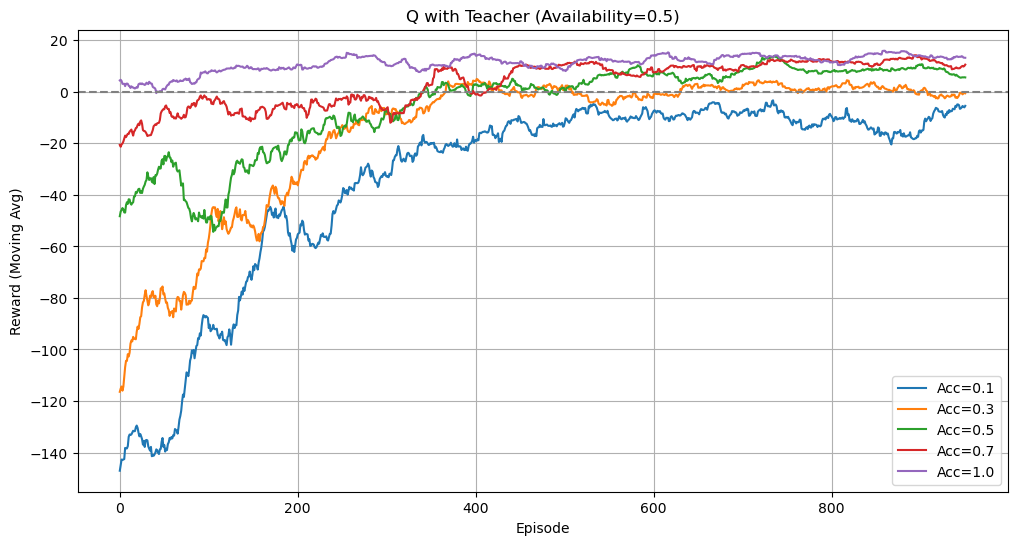

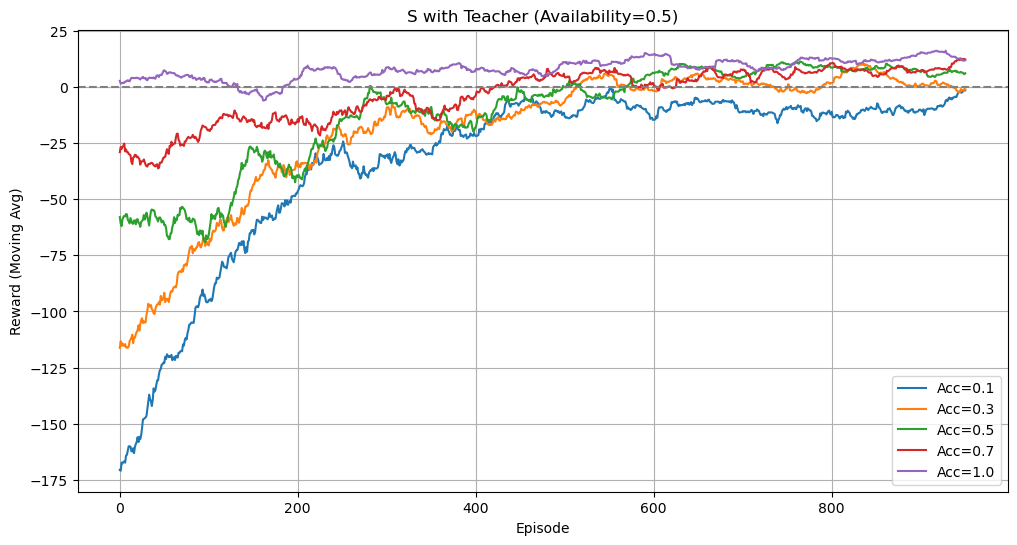

In [10]:
# === Additional Analysis: Teacher Impact Curves ===
def plot_teacher_accuracy_lines(env, teacher_q_table, algorithm, availability, accuracy_list=[0.1, 0.3, 0.5, 0.7, 1.0], episodes=1000):
    plt.figure(figsize=(12,6))
    for acc in accuracy_list:
        q_table = np.zeros((env.grid_size, env.grid_size, env.action_space))
        rewards = []
        epsilon = epsilon_start
        for episode in range(episodes):
            state = env.reset()
            total_reward = 0
            for step in range(max_steps):
                advise = random.random() < availability
                if advise:
                    best_action = np.argmax(teacher_q_table[state[0], state[1], :])
                    if random.random() < acc:
                        action = best_action
                    else:
                        choices = list(set(range(env.action_space)) - {best_action})
                        action = random.choice(choices)
                else:
                    action = np.argmax(q_table[state[0], state[1], :]) if random.random() > epsilon else np.random.randint(env.action_space)

                next_state, reward, done, _ = env.step(action)

                if algorithm == 'q':
                    best_next = np.argmax(q_table[next_state[0], next_state[1], :])
                    q_table[state[0], state[1], action] += alpha * (
                        reward + gamma * q_table[next_state[0], next_state[1], best_next] - q_table[state[0], state[1], action])
                elif algorithm == 's':
                    next_action = np.argmax(q_table[next_state[0], next_state[1], :]) if random.random() > epsilon else np.random.randint(env.action_space)
                    q_table[state[0], state[1], action] += alpha * (
                        reward + gamma * q_table[next_state[0], next_state[1], next_action] - q_table[state[0], state[1], action])
                    action = next_action

                state = next_state
                total_reward += reward
                if done:
                    break
            epsilon = max(epsilon_end, epsilon * epsilon_decay)
            rewards.append(total_reward)
        ma = moving_average(rewards)
        plt.plot(ma, label=f"Acc={acc}")

    plt.title(f"{algorithm.upper()} with Teacher (Availability={availability})")
    plt.xlabel("Episode")
    plt.ylabel("Reward (Moving Avg)")
    plt.axhline(0, color='gray', linestyle='--')
    plt.legend()
    plt.grid(True)
    plt.show()

# === Example Usage ===
plot_teacher_accuracy_lines(env, q_table_q, 'q', availability=0.5,episodes=1000)
plot_teacher_accuracy_lines(env, q_table_s, 's', availability=0.5,episodes=1000)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1078.76it/s]


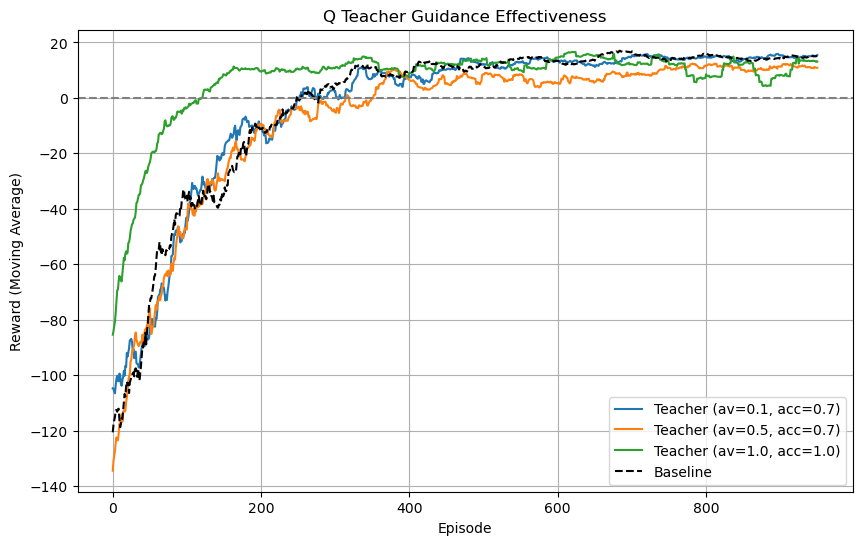

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1492.70it/s]


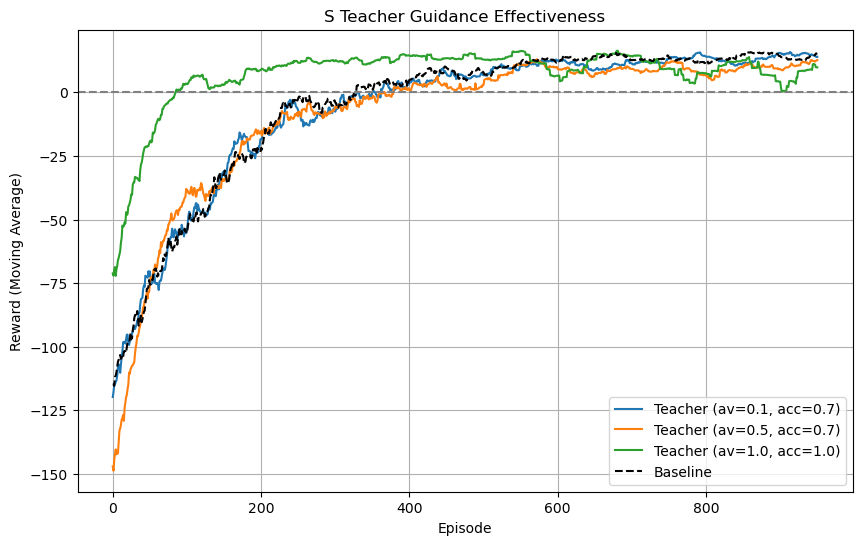

In [11]:
# === Comparative Teacher Effectiveness Plot ===
def plot_teacher_comparison(env, teacher_q_table, algorithm='q', episodes=1000):
    configs = [
        (0.1, 0.7),  # light advice
        (0.5, 0.7),  # moderate advice
        (1.0, 1.0)   # perfect teacher
    ]
    reward_dict = {}

    for avail, acc in configs:
        q_table = np.zeros((env.grid_size, env.grid_size, env.action_space))
        rewards = []
        epsilon = epsilon_start
        for episode in range(episodes):
            state = env.reset()
            total_reward = 0
            for step in range(max_steps):
                advise = random.random() < avail
                if advise:
                    best_action = np.argmax(teacher_q_table[state[0], state[1], :])
                    if random.random() < acc:
                        action = best_action if random.random() > epsilon else np.random.randint(env.action_space)
                    else:
                        action = random.choice(list(set(range(env.action_space)) - {best_action}))
                else:
                    action = np.argmax(q_table[state[0], state[1], :]) if random.random() > epsilon else np.random.randint(env.action_space)

                next_state, reward, done, _ = env.step(action)

                if algorithm == 'q':
                    best_next = np.argmax(q_table[next_state[0], next_state[1], :])
                    q_table[state[0], state[1], action] += alpha * (
                        reward + gamma * q_table[next_state[0], next_state[1], best_next] - q_table[state[0], state[1], action])
                elif algorithm == 's':
                    next_action = np.argmax(q_table[next_state[0], next_state[1], :]) if random.random() > epsilon else np.random.randint(env.action_space)
                    q_table[state[0], state[1], action] += alpha * (
                        reward + gamma * q_table[next_state[0], next_state[1], next_action] - q_table[state[0], state[1], action])
                    action = next_action

                state = next_state
                total_reward += reward
                if done:
                    break

            epsilon = max(epsilon_end, epsilon * epsilon_decay)
            rewards.append(total_reward)

        label = f"Teacher (av={avail}, acc={acc})"
        reward_dict[label] = moving_average(rewards)

    # Baseline (no teacher)
    _, baseline_rewards, _, _ = q_learning(env) if algorithm == 'q' else sarsa(env)
    reward_dict['Baseline'] = moving_average(baseline_rewards)

    # Plot
    plt.figure(figsize=(10, 6))
    for label, curve in reward_dict.items():
        if label == 'Baseline':
            plt.plot(curve, label=label, linestyle='--', color='black')
        else:
            plt.plot(curve, label=label)

    plt.axhline(0, linestyle='--', color='gray')
    plt.xlabel("Episode")
    plt.ylabel("Reward (Moving Average)")
    title = f"{algorithm.upper()} Teacher Guidance Effectiveness"
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example Usage:
plot_teacher_comparison(env, q_table_q, 'q')
plot_teacher_comparison(env, q_table_s, 's')

## 📊 Teacher Guidance Comparison 
 
The following plots compare different teacher configurations for Q-learning and SARSA algorithms:

- **Teacher (av=1.0, acc=1.0)** provides the fastest convergence and highest final rewards.
- **Teacher (av=0.5, acc=0.7)** shows clear improvement over baseline but less steep.
- **Teacher (av=0.1, acc=0.7)** has a small effect, only slightly outperforming no-teacher baseline.
- **Baseline** learners (no teacher) learn more slowly and exhibit lower final performance.

### Insights:
- High-availability, high-accuracy teachers are most effective early in training.
- Occasional inaccurate advice can still help, but only when availability is sufficiently high.
- SARSA tends to improve more steadily, while Q-learning shows sharper gains under teacher guidance.

These results reinforce that reinforcement learning benefits from accurate external guidance, especially in early episodes where exploration dominates.